In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import glob

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/DDoSdata.csv


## 1. Data Prep.

In [3]:
df = pd.read_csv('/kaggle/input/DDoSdata.csv', delimiter=',')
df = df.drop(df.columns[[0,1]],axis=1)
df.dataframeName = 'DDoSdata.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 1927101 rows and 45 columns


In [4]:
df.head()

,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,pkts,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1.528103e+09,e,1,tcp,1,192.168.100.150,54110,192.168.100.3,80,10,...,1.21662,40,38,1.56093,1.21662,328,308,1,DDoS,HTTP
1,1.528103e+09,e,1,tcp,1,192.168.100.150,54112,192.168.100.3,80,10,...,1.21662,40,38,1.56107,1.21662,328,308,1,DDoS,HTTP
2,1.528103e+09,e,1,tcp,1,192.168.100.150,54114,192.168.100.3,80,8,...,1.21662,40,38,1.24980,1.21662,328,308,1,DDoS,HTTP
3,1.528103e+09,e,1,tcp,1,192.168.100.150,54116,192.168.100.3,80,8,...,1.21662,40,38,1.24986,1.21662,328,308,1,DDoS,HTTP
4,1.528103e+09,e,1,tcp,1,192.168.100.150,54118,192.168.100.3,80,8,...,1.21662,40,38,1.24991,1.21662,328,308,1,DDoS,HTTP


Check distribution of **target** variable. The Dataset is aiming for build detection system so there are mostly positive cases, namely, imbalanced classification.

In [5]:
df.groupby(["attack","category","subcategory"])["attack"].count()

attack  category  subcategory
0       Normal    Normal            477
1       DDoS      HTTP              989
                  TCP            977380
                  UDP            948255
Name: attack, dtype: int64

In [6]:
df.dtypes

stime                               float64
flgs                                 object
flgs_number                           int64
proto                                object
proto_number                          int64
saddr                                object
sport                                object
daddr                                object
dport                                object
pkts                                  int64
bytes                                 int64
state                                object
state_number                          int64
ltime                               float64
seq                                   int64
dur                                 float64
mean                                float64
stddev                              float64
sum                                 float64
min                                 float64
max                                 float64
spkts                                 int64
dpkts                           

In [7]:
df.isna().sum()

stime                               0
flgs                                0
flgs_number                         0
proto                               0
proto_number                        0
saddr                               0
sport                               0
daddr                               0
dport                               0
pkts                                0
bytes                               0
state                               0
state_number                        0
ltime                               0
seq                                 0
dur                                 0
mean                                0
stddev                              0
sum                                 0
min                                 0
max                                 0
spkts                               0
dpkts                               0
sbytes                              0
dbytes                              0
rate                                0
srate       

In [8]:
df.describe()

,stime,flgs_number,proto_number,pkts,bytes,state_number,ltime,seq,dur,mean,...,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack
count,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,...,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06,1.927101e+06
mean,1.528097e+09,1.442916e+00,1.984566e+00,7.913937e+00,1.126113e+03,3.043337e+00,1.528097e+09,1.232456e+05,1.484886e+01,2.549126e+00,...,7.340666e+02,1.337962e+00,1.806924e+00,9.988476e+01,8.194398e+01,8.421088e-01,1.418524e+00,6.771640e+02,5.741962e+02,9.997525e-01
std,2.756896e+04,6.024243e-01,9.998889e-01,1.591975e+02,1.548951e+05,1.191149e+00,2.756568e+04,7.380114e+04,1.238456e+01,1.404565e+00,...,8.333697e+02,8.717285e+01,2.242319e+02,2.628704e+00,2.422842e+01,6.318281e+01,6.320693e+01,5.036687e+02,4.717024e+02,1.573089e-02
min,1.526344e+09,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+01,1.000000e+00,1.526344e+09,1.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.528096e+09,1.000000e+00,1.000000e+00,5.000000e+00,4.200000e+02,3.000000e+00,1.528096e+09,6.004700e+04,1.212153e+01,2.015834e+00,...,5.000000e+02,3.594890e-01,3.703380e-01,1.000000e+02,6.800000e+01,3.502690e-01,3.703120e-01,3.650000e+02,2.680000e+02,1.000000e+00
50%,1.528096e+09,1.000000e+00,1.000000e+00,7.000000e+00,6.160000e+02,3.000000e+00,1.528096e+09,1.202690e+05,1.368344e+01,2.759683e+00,...,6.820000e+02,5.410290e-01,5.497720e-01,1.000000e+02,9.700000e+01,5.437660e-01,5.496870e-01,6.270000e+02,5.000000e+02,1.000000e+00
75%,1.528099e+09,2.000000e+00,3.000000e+00,1.000000e+01,7.800000e+02,4.000000e+00,1.528099e+09,1.831610e+05,1.454814e+01,3.659851e+00,...,9.520000e+02,7.588950e-01,7.534680e-01,1.000000e+02,1.000000e+02,7.286400e-01,7.534480e-01,9.480000e+02,7.840000e+02,1.000000e+00
max,1.528103e+09,7.000000e+00,5.000000e+00,7.005700e+04,7.183334e+07,8.000000e+00,1.528103e+09,2.621680e+05,1.940859e+03,4.981882e+00,...,2.444250e+05,8.695650e+04,1.818180e+05,1.000000e+02,1.000000e+02,8.695650e+04,8.695650e+04,1.125440e+05,1.179390e+05,1.000000e+00


## 2. Data Visulization

Firstly, get the list of numeric and categorical variable.

In [9]:
li_cat = df.select_dtypes(['object']).columns.to_list()
li_num = [item for item in df.columns.to_list() if item not in li_cat]

#### Continuous Variables
It is normal for network data to have a wide distribution.

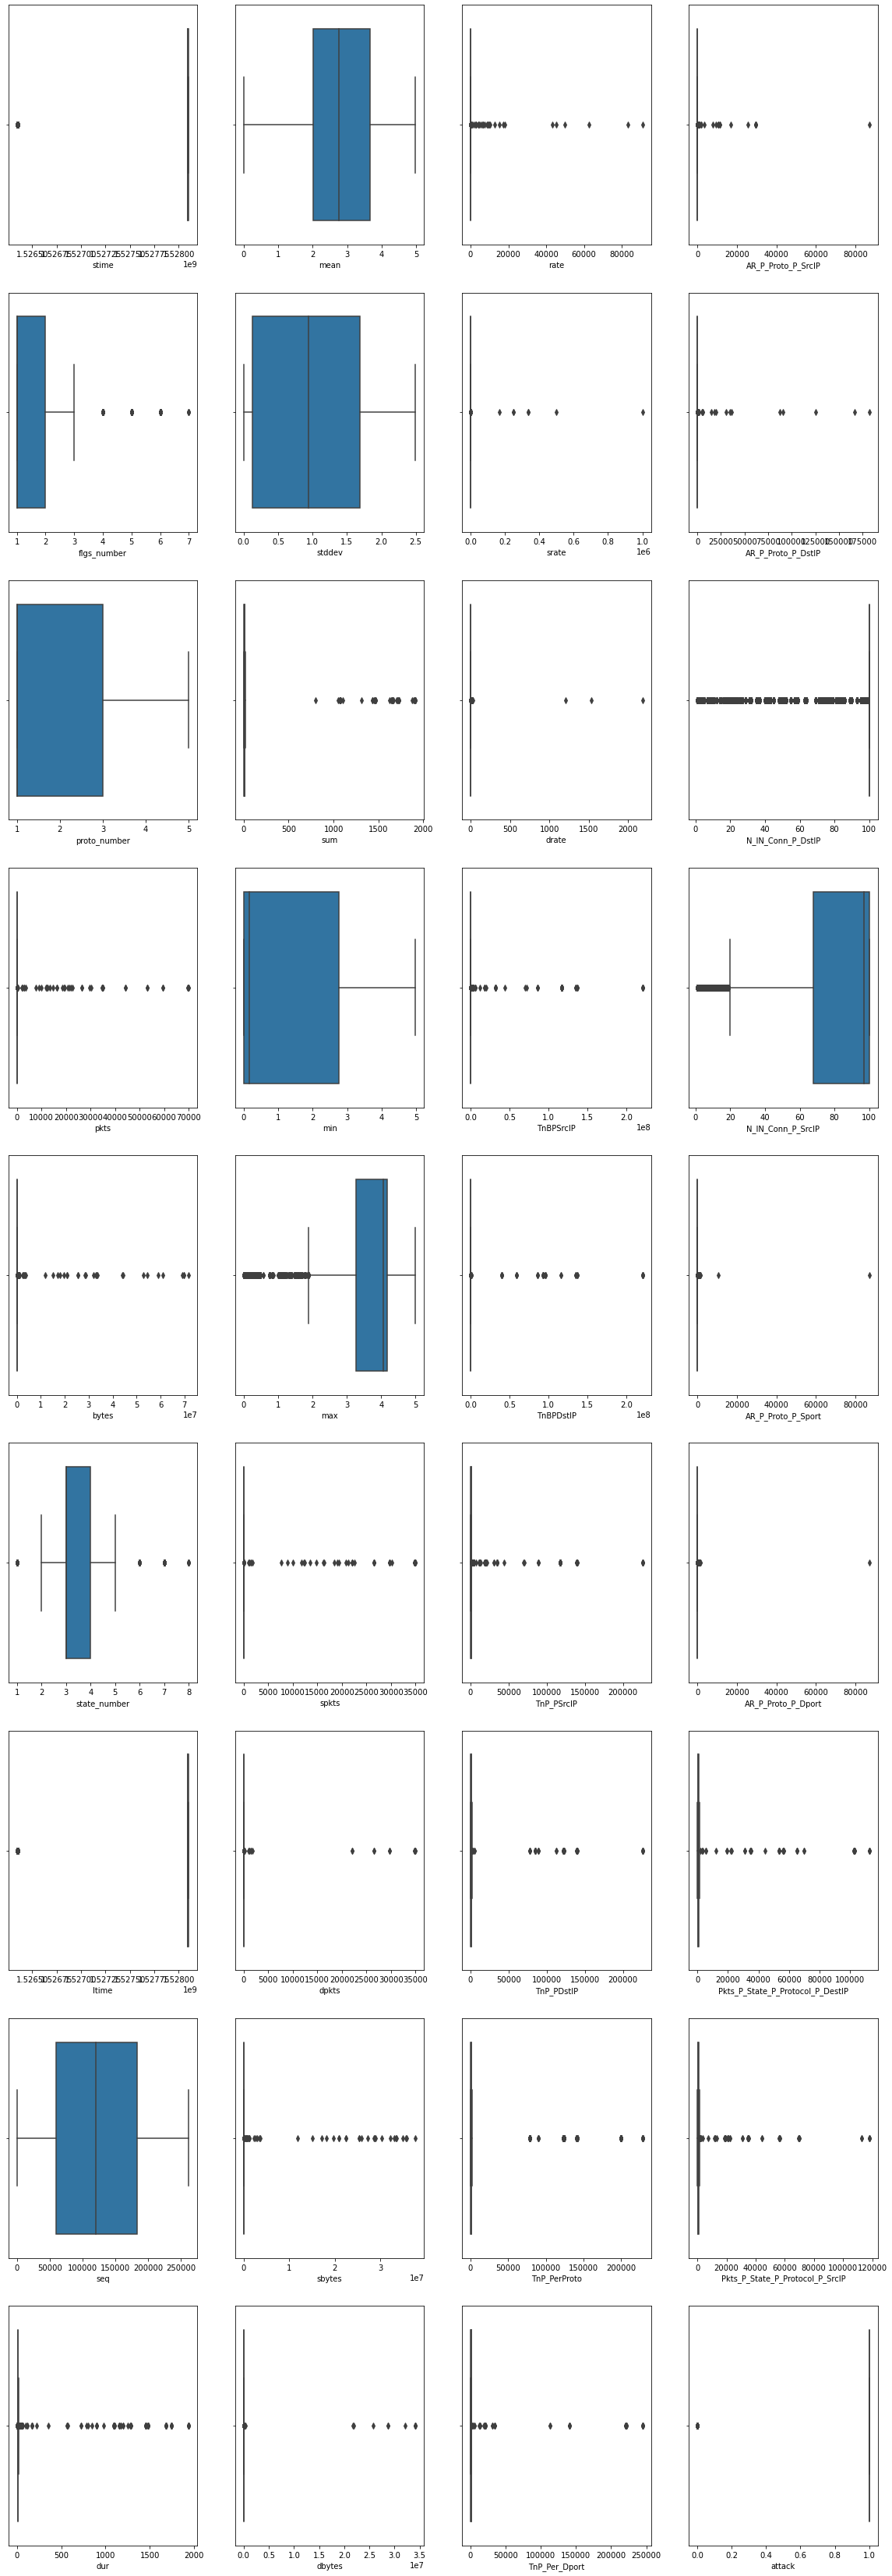

In [10]:
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(20, 60))
for idx, feature in enumerate(df[li_num]):
    sns.boxplot(x=df[feature], ax=axes[idx % 9, idx // 9])


It is normal for network data to have a wide-range or shifted distribution. So we will only draw graph for those with relatively normal distribution.

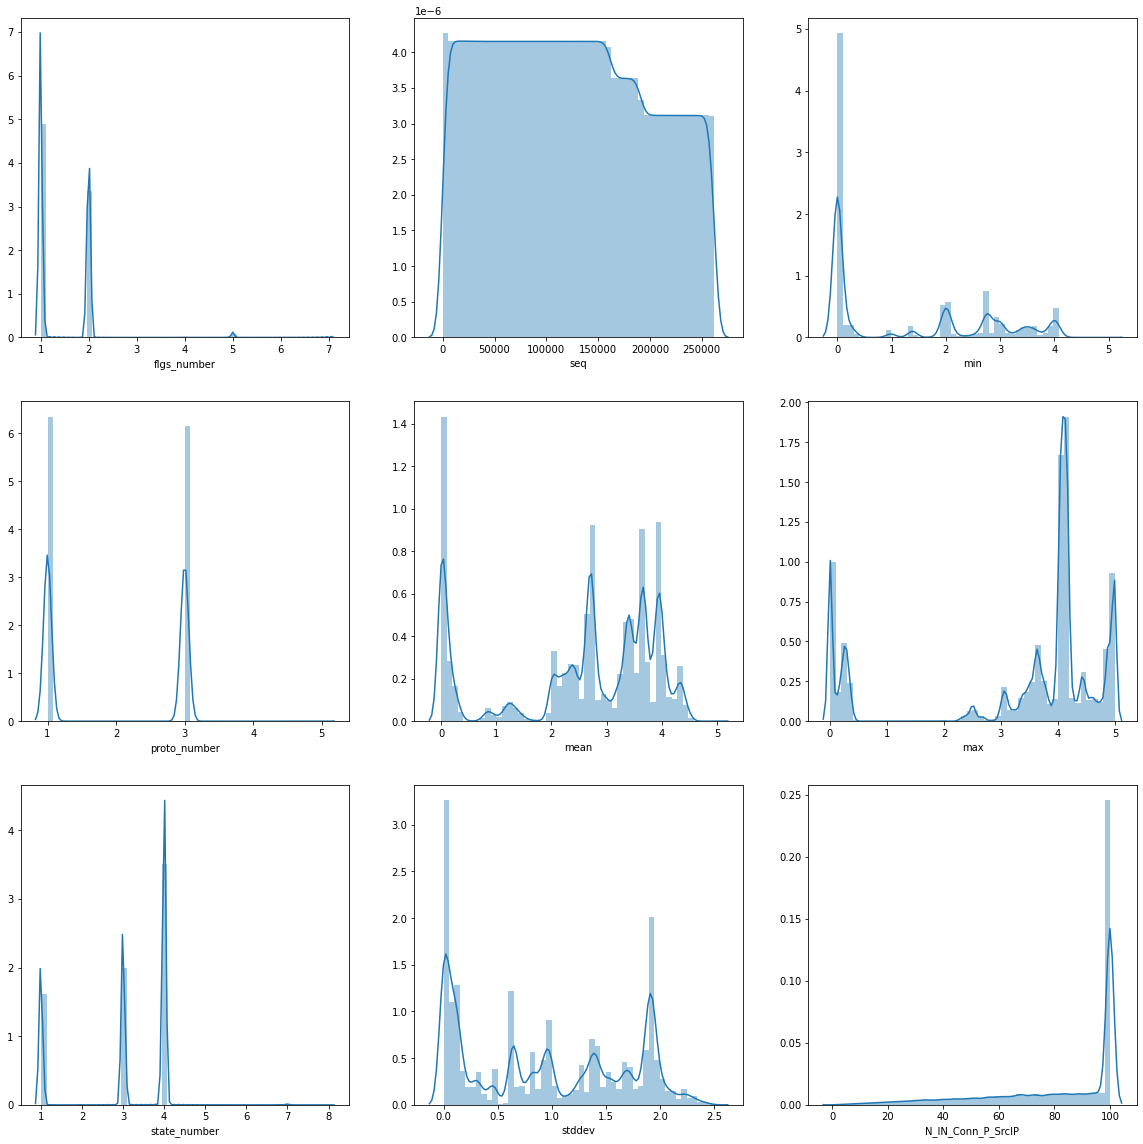

In [11]:
to_draw = ['flgs_number','proto_number','state_number','seq','mean','stddev','min','max','N_IN_Conn_P_SrcIP']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
for idx, feature in enumerate(df[to_draw]):
    sns.distplot(df[feature], bins=50, ax=axes[idx % 3, idx // 3])

#### Categotical Data Counting

In [12]:
for idx, feature in enumerate(df[li_cat]):
    print(df[feature].value_counts())

e      1129681
e s     778517
e g      17825
e *        809
eU         247
e d         17
e &          5
Name: flgs, dtype: int64
tcp          978397
udp          948598
arp              82
icmp             16
ipv6-icmp         8
Name: proto, dtype: int64
192.168.100.147              520012
192.168.100.148              494696
192.168.100.150              457002
192.168.100.149              451641
192.168.100.3                  3625
192.168.100.4                    19
192.168.100.1                    16
192.168.100.46                   15
192.168.100.27                   14
192.168.100.7                    13
192.168.100.5                    12
192.168.100.6                    11
fe80::250:56ff:febe:254           6
fe80::c0c0:aa20:45b9:bdd9         4
192.168.100.55                    3
fe80::250:56ff:febe:26db          2
fe80::250:56ff:febe:89ee          2
fe80::250:56ff:febe:bf1a          2
fe80::250:56ff:febe:c038          2
fe80::250:56ff:febe:e9d9          2
fe80::2c6a:ff9b:7e14:166

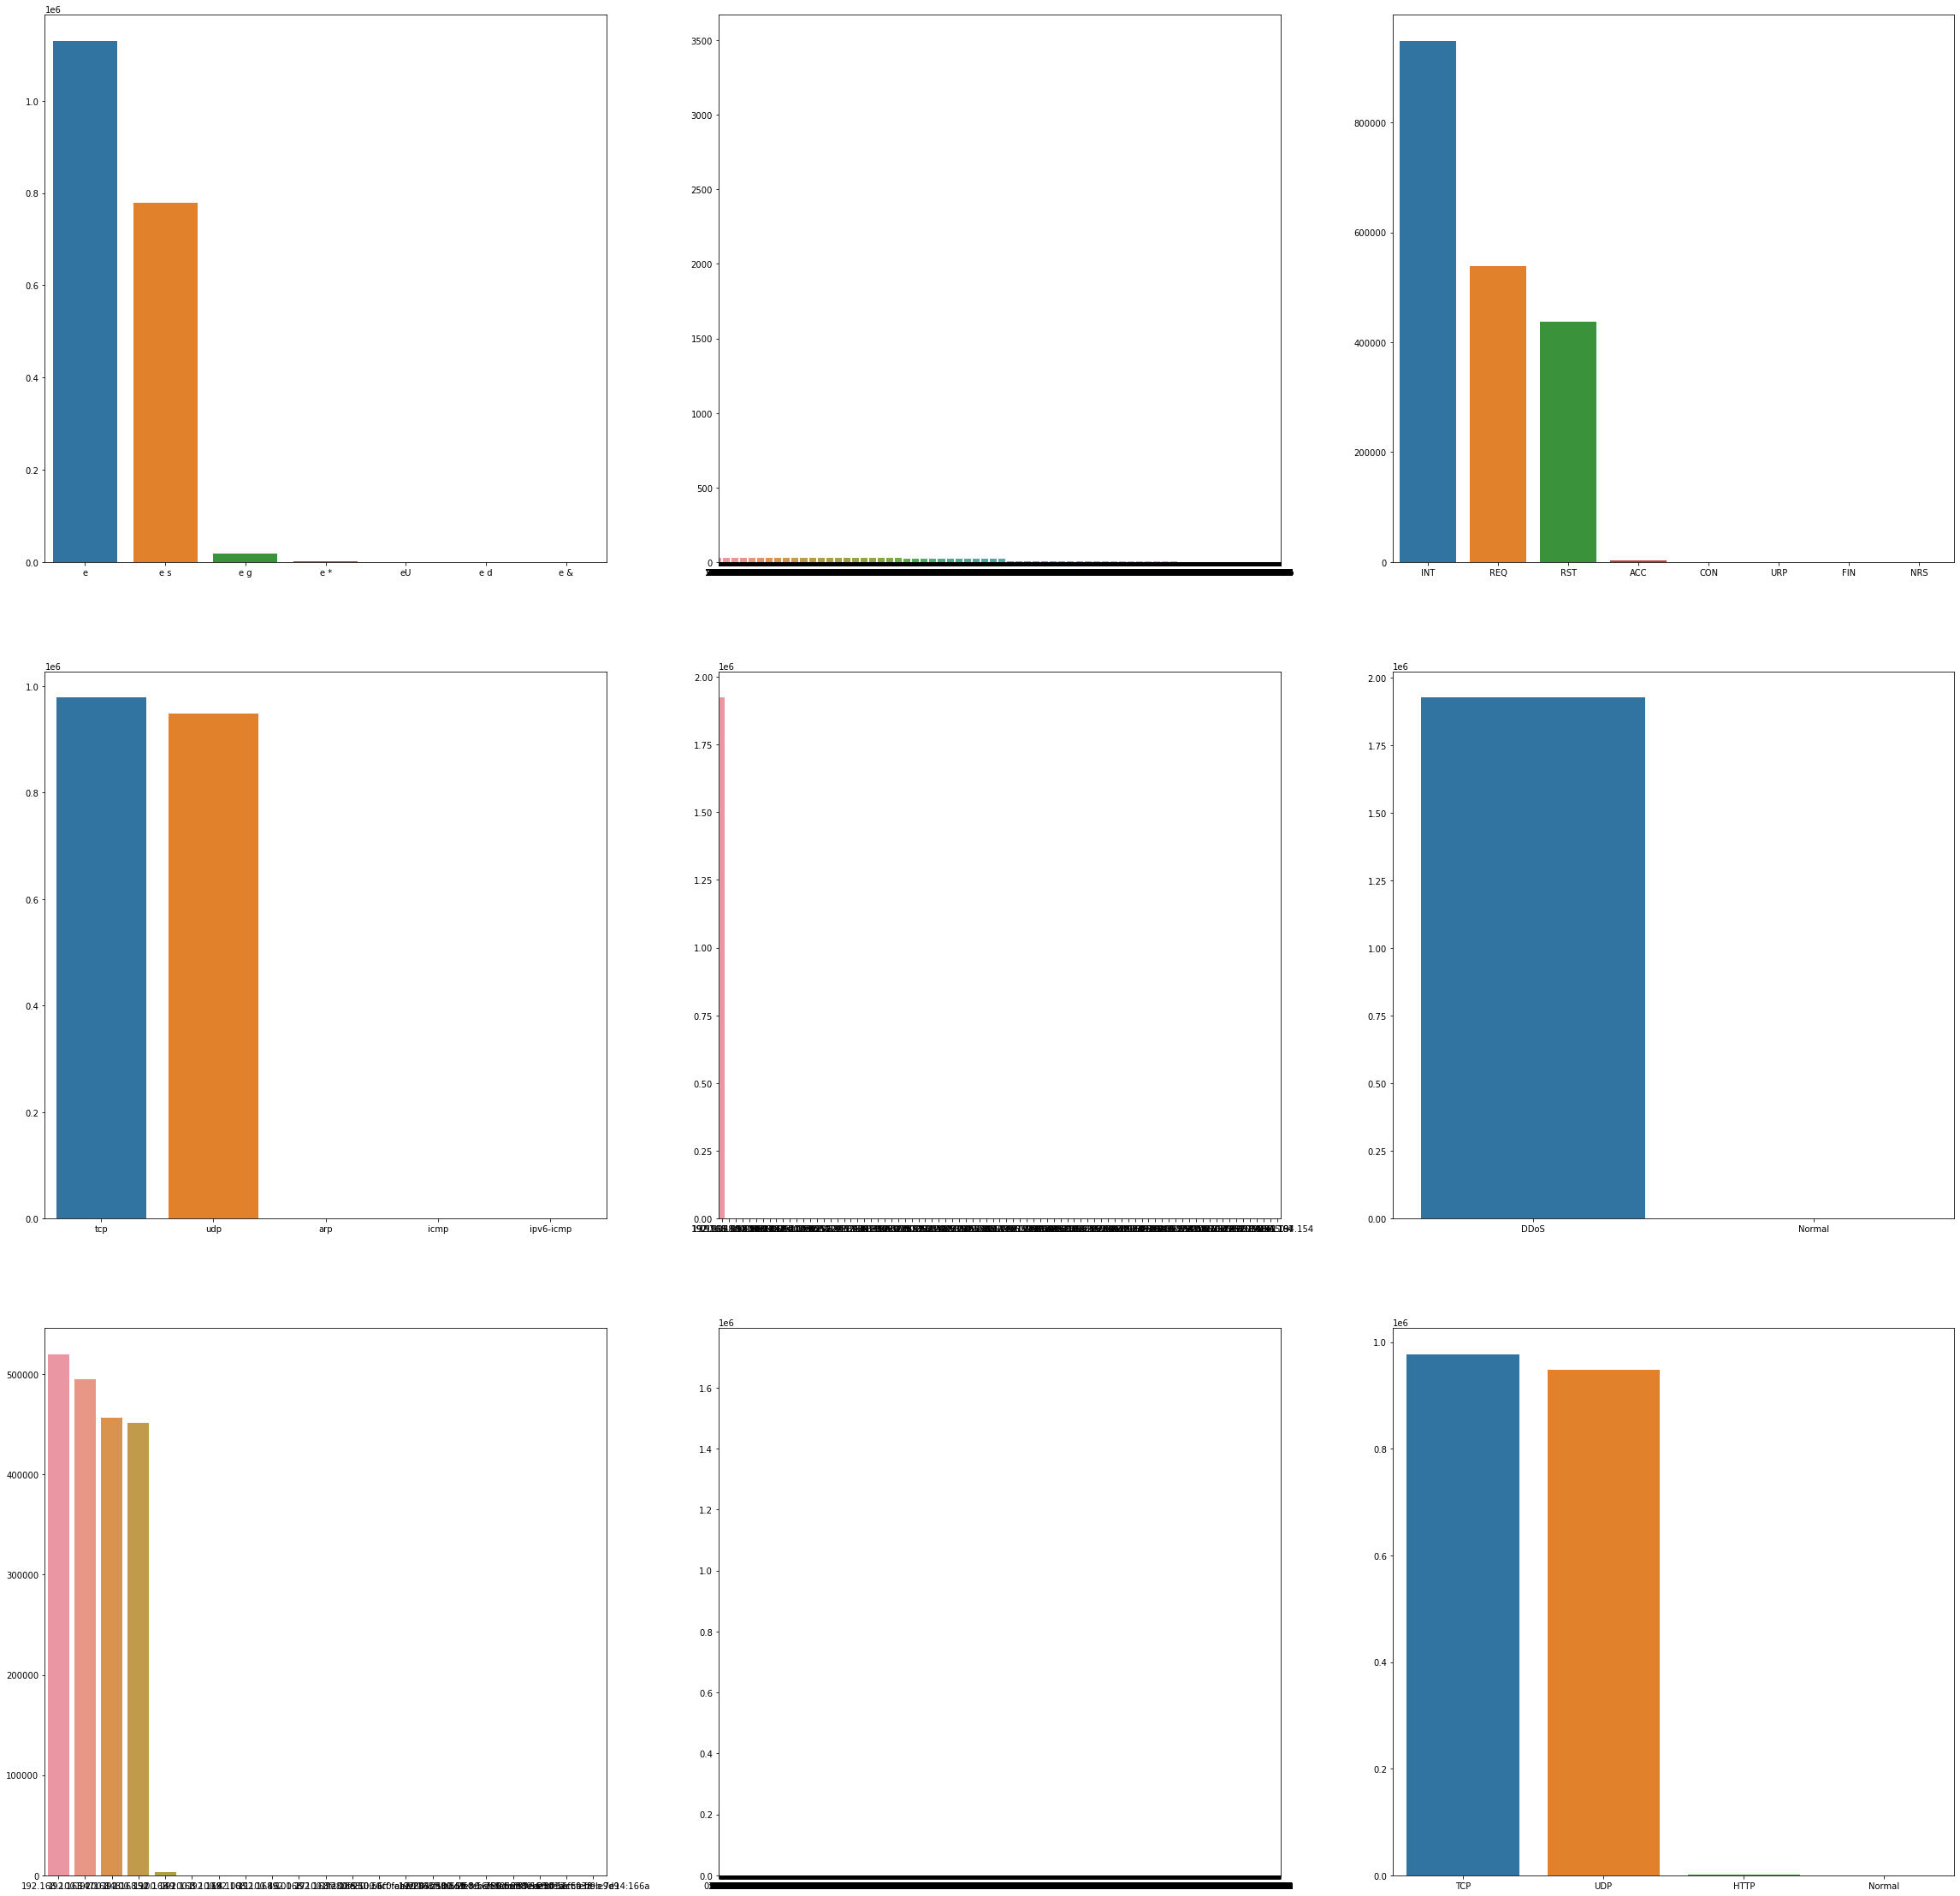

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(40,40))
for idx, feature in enumerate(df[li_cat]):
    y = df[feature].value_counts().values
    x = np.array(df[feature].value_counts().to_frame().index)
    sns.barplot(x=x, y=y, ax=axes[idx % 3, idx // 3])

### Correlation matrix

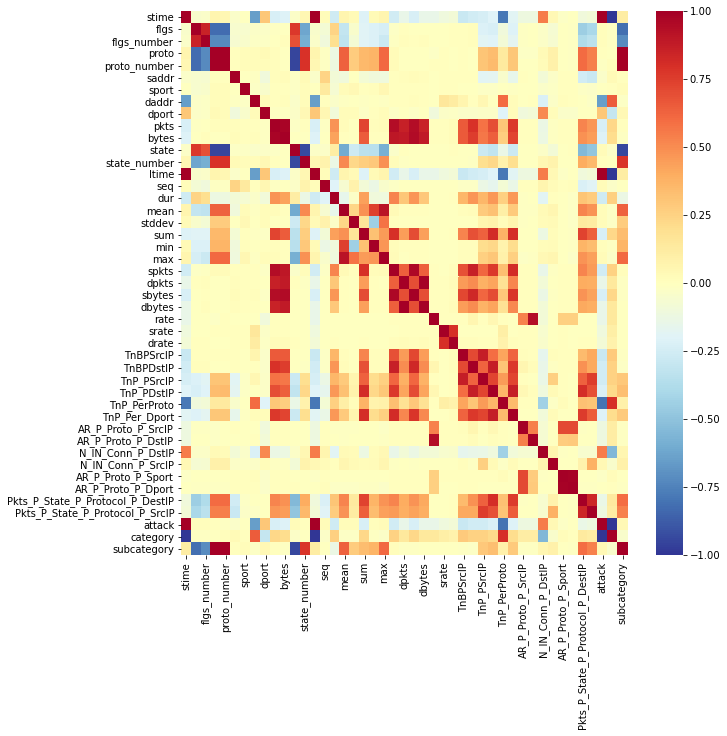

In [14]:
num_df = df
le = LabelEncoder()
for col in li_cat:
        num_df[col] = le.fit_transform(num_df[col].astype(str))
plt.figure(figsize=(10,10))
sns.heatmap(num_df.corr(), cmap="RdYlBu_r")

### PCA

In [15]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(num_df)

In [16]:
model_3 = PCA(n_components=3)
model_3.fit(df_scaled)
df_pca_3 = model_3.transform(df_scaled)

In [17]:
model_4 = PCA(n_components=4)
model_4.fit(df_scaled)
df_pca_4 = model_4.transform(df_scaled)

In [18]:
model_5 = PCA(n_components=5)
model_5.fit(df_scaled)
df_pca_5 = model_5.transform(df_scaled)

In [19]:
print("Component No.:",len(model_3.explained_variance_ratio_))
print(model_3.explained_variance_ratio_)
print("Component No.:",len(model_4.explained_variance_ratio_))
print(model_4.explained_variance_ratio_)
print("Component No.:",len(model_5.explained_variance_ratio_))
print(model_5.explained_variance_ratio_)

Component No.: 3
[0.2515033  0.16733498 0.10899353]
Component No.: 4
[0.2515033  0.16733498 0.10899353 0.07082518]
Component No.: 5
[0.2515033  0.16733498 0.10899353 0.07082518 0.04546539]


Plot PCA with Ploty.

The diagram shows the cumulative percentage of explained explainability.

In [38]:
exp_var_cumul = np.cumsum(model_5.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

### Lasso Regression
This is used for feature selection.

In [29]:
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskElasticNet
def feature_selection(x,y): 
    lasso_selection = Lasso(alpha=0.3,max_iter=20000)
    lasso_coef = lasso_selection.fit(x,y).coef_
    print('Selected features: ',str(len(lasso_coef[lasso_coef!=0.0])))

    # Making a list from selected features
    val = lasso_coef[lasso_coef!=0.0]
    key, = np.where(lasso_coef!=0.0)
    feature_list = x.columns[key]
    val_plt = np.multiply(val,1000)
    feature_list = feature_list.tolist()
    feature_column = key.tolist()
    val = val.tolist()
    
    print(feature_list)
    return x[feature_list]
for col in ['attack','subcategory']:#'attack','subcategory'-multi-label classification, binary classification
    globals()[f"x_{col}"] = feature_selection(num_df.iloc[:,0:42], num_df[col])
    print("Feature selection finished.")

Selected features:  8
['stime', 'sport', 'ltime', 'seq', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PerProto', 'Pkts_P_State_P_Protocol_P_DestIP']
Feature selection finished.
Selected features:  17
['stime', 'flgs', 'sport', 'pkts', 'bytes', 'seq', 'dur', 'sbytes', 'srate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'AR_P_Proto_P_DstIP', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP']
Feature selection finished.


In [30]:
from sklearn.model_selection import train_test_split
X_binary,y_binary = np.array(x_attack), np.array(num_df.iloc[:,-3:-2])
y_binary = y_binary.reshape(y_binary.shape[0],)
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(X_binary, y_binary, test_size=0.3, random_state=42)

In [31]:
# multi-class
X_multi,y_multi = np.array(x_subcategory), np.array(num_df.iloc[:,-1])
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)

In [32]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

### AdaBoost

Firstly - the binary classification.

In [34]:
adb_binary = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
    max_features=None, max_leaf_nodes=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, random_state=None,
    splitter='best'), n_estimators=100, random_state=0, learning_rate=0.001)
adb_binary.fit(X_binary_train, y_binary_train)
pred_binary = adb_binary.predict(X_binary_test)
print("On training_set:",adb_binary.score(X_binary_train, y_binary_train))
print("On testing_set:",adb_binary.score(X_binary_test, y_binary_test))

On training_set: 1.0
On testing_set: 1.0


In [35]:
confusion_matrix(y_binary_test,pred_binary)

array([[   141,      0],
       [     0, 577990]])

In [36]:
### for binary classification
from sklearn.metrics import confusion_matrix
def rates(truey,predy):
	tn, fp, fn, tp = confusion_matrix(truey,predy).ravel()
	acc = (tp+tn)/(tp+fp+tn+fn)
	precision = tp/(tp+fp)
	recall = tp/(tp+fn)
	tpr = tp/(tp+fn)
	fpr = fp/(fp+tn)
	print(f"Accuracy\t {acc:.4f} \nPrecision\t {precision:.4f} \nRecall\t {recall:.4f} \nFalse Alarm\t {fpr:.4f} \nMissed Caases\t {tpr:.4f}")

In [37]:
rates(y_binary_test,pred_binary)

Accuracy	 1.0000 
Precision	 1.0000 
Recall	 1.0000 
False Alarm	 0.0000 
Missed Caases	 1.0000


Below is the multi-label classification.

In [39]:
adb_multi = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
    max_features=None, max_leaf_nodes=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, random_state=None,
    splitter='best'), n_estimators=100, random_state=0, learning_rate=0.001)
adb_multi.fit(X_multi_train, y_multi_train)
pred_multi = adb_multi.predict(X_multi_test)
print("On training_set:",adb_multi.score(X_multi_train, y_multi_train))
print("On testing_set:",adb_multi.score(X_multi_test, y_multi_test))

On training_set: 1.0
On testing_set: 1.0


In [40]:
confusion_matrix(y_multi_test,pred_multi)

array([[   284,      0,      0,      0],
       [     0,    141,      0,      0],
       [     0,      0, 293508,      0],
       [     0,      0,      0, 284198]])

In [44]:
print(classification_report(y_multi_test,pred_multi))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       1.00      1.00      1.00       141
           2       1.00      1.00      1.00    293508
           3       1.00      1.00      1.00    284198

    accuracy                           1.00    578131
   macro avg       1.00      1.00      1.00    578131
weighted avg       1.00      1.00      1.00    578131

